In [7]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import time

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [8]:
path2data = './data/raw_data.pkl'                                    # path to Data
start = time.time()                                                  # start loading time
with open(path2data, 'rb') as f:                                     # load data
    df = pickle.load(f)
end = time.time()                                                    # end loading time
print(f"Raw data loading time: {np.round(end - start, 2)} seconds")  # document loading time
memory_usage_GB = df.memory_usage(index=True).sum() * 1e-9           # memory usage
print(f"DataFrame occupies: {np.round(memory_usage_GB, 2)} GB")      # document memory usage

# Removes leading and trailing characters (whitespace by default)
# meaning was taken under consideration
df.columns = [col.strip() for col in list(df.columns)]
print(f"\nColumns Names (after striping):\n{df.columns}")

df = df.reset_index(drop=True)
print(f"Raw data shape: {df.shape}")                                 # raw data shape

# replace inf with nan temporarily for max value calculations
tmp = df[['Flow Bytes/s', 'Flow Packets/s']]
tmp = tmp.replace([-np.inf, np.inf], np.nan)
print(f"positive numpy inf in tmp: {tmp.columns[(tmp == np.inf).any()]}")
print(f"negative numpy inf in tmp: {tmp.columns[(tmp == -np.inf).any()]}")
max_dict = tmp.max().to_dict()

# replace inf with 10 * df['Flow Bytes/s'].max()
df['Flow Bytes/s'] = df['Flow Bytes/s'].replace(np.inf, 10 * max_dict['Flow Bytes/s'])     
# replace inf with 10 * df['Flow Packets/s'].max()
df['Flow Packets/s'] = df['Flow Packets/s'].replace(np.inf, 10 * max_dict['Flow Packets/s']) 

# check again for np.inf or -np.inf in data
print('post numpy inf replacement:')
print(f"positive numpy inf in data: {(df == np.inf).any().any()}")
print(f"negative numpy inf in data: {(df == -np.inf).any().any()}")

# check for NA values in data
print('NA values are in:')
print(df.columns[df.isna().any()])

modes =  df.mode().T.to_dict()[0]  # get modes
del modes['Label']                 # delete Label
del modes['source']                # delete source
    
# fill missing data
for col in list(df.columns):
    if df[col].isna().any():
        df[col] = df[col].fillna(modes[col])
        print(f"NaNs were found in {col} and replaced by the value {modes[col]}")
print(f"Missing data (after fillna): {df.isna().any().any()}")  

Raw data loading time: 2.63 seconds
DataFrame occupies: 1.83 GB

Columns Names (after striping):
Index(['Destination Port', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Total Length of Fwd Packets',
       'Total Length of Bwd Packets', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
       'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Min Packet Length', 'Max Packet Length', 'Packet Length M

Feature Distributions

In [3]:
for col in df.columns:
    try:
        if col in ['Label', 'source']:
            continue
        figname = (col + '.png').replace('/', ' ')
        plt.figure()
        df[col].hist(grid=False, alpha=0.5, ec='black')
        plt.title(col + ' Distribution')
        plt.xlabel('Value')
        plt.ylabel('Count')
        plt.savefig(os.path.join('Images/Feature_Distribution', figname))
        plt.close('all')
    except Exception as inst:
        print(col)
        print(inst)

BoxPlot

In [4]:
for col in df.columns:
    try:
        if col in ['Label', 'source']:
            continue
        figname = (col + '.png').replace('/', ' ')
        plt.figure()
        plt.boxplot(df[col])
        plt.xticks([1], [col])
        plt.title(col + ' BoxPlot')
        plt.savefig(os.path.join('Images/BoxPlot', figname))
        plt.close('all')
    except Exception as inst:
        print(col)
        print(inst)

PCA

In [9]:
df = df.drop(['Label', 'source'], axis=1)
# Scale features
x = StandardScaler().fit_transform(df.values)

# PCA
pca = PCA(n_components=0.95)

principalComponents = pca.fit_transform(x)

principal_df = pd.DataFrame(principalComponents, 
                            columns = ['PC ' + str(i + 1) for i in range(principalComponents.shape[1])])

The explained variance tells how much information (variance) can be attributed to each of the principal components.

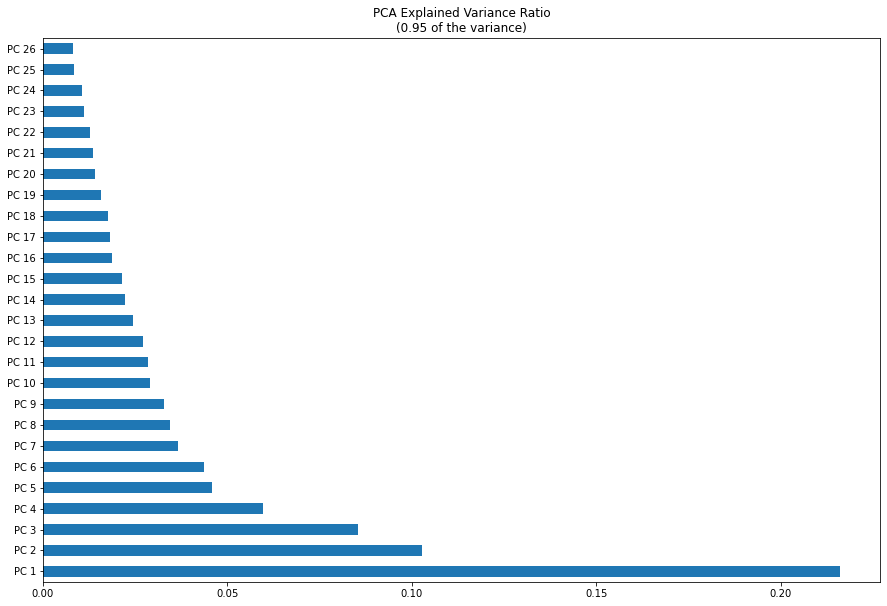

In [10]:
pca_explained_variance_ratio_ = pd.Series(pca.explained_variance_ratio_, index=principal_df.columns)

plt.figure(figsize=(15, 10))
pca_explained_variance_ratio_.plot.barh()
plt.title('PCA Explained Variance Ratio\n(0.95 of the variance)')
plt.savefig('Images/PCA/Explained_Variance_Ratio.png')
plt.show()